# RUOD processing

## Dataset Setup

Using the RUOD dataset:

Mark that this is done in the semester project. But the end result should be having the data inside processed/images/{train,test} and  processed/lables/{train, test}. Because the original RUOD set does not have a validation set we create it here. 

First steps:

- Download the dataset from [here](https://github.com/xiaoDetection/RUOD?tab=readme-ov-file). I recommend using the Google option.
- Place the downloaded .zip file inside the RUOD/-folder
- Then unzip it manually or running code below (OLD CODE):

In [1]:
# import zipfile
# import os

# zip_path = "../data/RUOD.zip"
# extract_dir = "../data/RUOD/"

# # Make sure the target directory exists
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print("✅ RUOD dataset extracted to:", os.path.abspath(extract_dir))


### Make labels on right format. COCO -> YOLO

OLD CODE!!

In [ ]:
# import json, os
# from pathlib import Path
# from collections import defaultdict

# ROOT = Path("../data/RUOD")
# IMAGES = ROOT/"RUOD_pic"
# ANN    = ROOT/"RUOD_ANN"

# def clip(v, lo, hi): return max(lo, min(hi, v))

# def convert(split, coco_json):
#     labels_dir = ROOT/"labels"/split
#     labels_dir.mkdir(parents=True, exist_ok=True)
#     coco = json.loads(Path(coco_json).read_text())

#     id2img = {im["id"]: im for im in coco["images"]}
#     byimg = defaultdict(list)
#     for a in coco["annotations"]:
#         if a.get("iscrowd",0)==1 or a.get("ignore",0)==1:
#             continue
#         byimg[a["image_id"]].append(a)

#     # build contiguous class map from categories order
#     sorted_cats = sorted(coco["categories"], key=lambda c: c["id"])
#     cat2idx = {c["id"]: i for i,c in enumerate(sorted_cats)}

#     written = 0
#     for img_id, img in id2img.items():
#         img_path = IMAGES/split/img["file_name"]
#         if not img_path.exists():
#             continue
#         W,H = img["width"], img["height"]
#         lines=[]
#         for ann in byimg.get(img_id, []):
#             x,y,w,h = ann["bbox"]
#             x = clip(x,0,W); y = clip(y,0,H)
#             w = clip(w,0,W-x); h = clip(h,0,H-y)
#             if w<=0 or h<=0: continue
#             xc = (x+w/2)/W; yc=(y+h/2)/H
#             wn = w/W; hn=h/H
#             cls = cat2idx[ann["category_id"]]
#             lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")
#         if lines:
#             (labels_dir/(Path(img["file_name"]).stem+".txt")).write_text("\n".join(lines))
#             written+=1
#     print(f"{split}: wrote labels for {written} images")

# convert("train", ANN/"instances_train.json")
# convert("test",  ANN/"instances_test.json")


train: wrote labels for 9800 images
test: wrote labels for 4200 images


### Write yaml config file

In [1]:
from pathlib import Path


RUOD_ROOT = Path.cwd()             

DATA = RUOD_ROOT / "processed" 
IMAGES_TRAIN = DATA / "images" / "train"
IMAGES_VAL = DATA / "images" / "val"
IMAGES_TEST   = DATA / "images" / "test"        # or use a dedicated val split if you have one

dataset_yaml = f"""
train: {IMAGES_TRAIN.as_posix()}
val:   {IMAGES_VAL.as_posix()}
test:  {IMAGES_TEST.as_posix()}

# RUOD has 10 classes
names:
  - holothurian
  - echinus
  - scallop
  - starfish
  - fish
  - coral
  - diver
  - cuttlefish
  - turtle
  - jellyfish
"""
(RUOD_ROOT / "ruod.yaml").write_text(dataset_yaml)
print("Wrote:", RUOD_ROOT / "ruod.yaml")


Wrote: /cluster/home/henrban/aquaculture-perception/data-processing/vision/RUOD/ruod.yaml


### RUOD with validation set. 

OLD CODE but we get a validation set by taking 1960 images from the training set. 

In [ ]:
# from pathlib import Path
# import shutil
# import random

# # ----------------------------
# # Config
# # ----------------------------
# NOT_ROOT = Path.cwd()              
# ROOT = NOT_ROOT.parent

# RUOD_DIR = ROOT / "data" / "RUOD"
# OUT_DIR = ROOT / "data" / "RUOD_fix"
# VAL_COUNT = 1960
# SEED = 42                              # change for a different random split

# # YOLO image extensions you might have
# IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# # If a label is missing, either:
# # - set to True to create an empty .txt label file in the destination
# # - set to False to raise an error
# CREATE_EMPTY_LABEL_IF_MISSING = True


# def ensure_dir(p: Path) -> None:
#     p.mkdir(parents=True, exist_ok=True)


# def copy_tree(src: Path, dst: Path) -> None:
#     """Copy all files in a folder (non-recursive) to another folder."""
#     ensure_dir(dst)
#     for f in src.iterdir():
#         if f.is_file():
#             shutil.copy2(f, dst / f.name)


# def image_files(folder: Path):
#     return [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in IMG_EXTS]


# def label_path_for_image(img_path: Path, labels_root: Path) -> Path:
#     # YOLO format: label filename matches image stem, with .txt extension
#     return labels_root / f"{img_path.stem}.txt"


# def copy_image_and_label(img: Path, labels_root: Path, out_img_dir: Path, out_lbl_dir: Path):
#     ensure_dir(out_img_dir)
#     ensure_dir(out_lbl_dir)

#     out_img = out_img_dir / img.name
#     shutil.copy2(img, out_img)

#     src_lbl = label_path_for_image(img, labels_root)
#     out_lbl = out_lbl_dir / src_lbl.name

#     if src_lbl.exists():
#         shutil.copy2(src_lbl, out_lbl)
#     else:
#         if CREATE_EMPTY_LABEL_IF_MISSING:
#             out_lbl.write_text("")  # empty label file
#         else:
#             raise FileNotFoundError(f"Missing label for image: {img.name} expected {src_lbl}")


# def move_image_and_label_within_out(img_name: str, out_images_dir: Path, out_labels_dir: Path,
#                                     src_split: str, dst_split: str):
#     src_img = out_images_dir / src_split / img_name
#     dst_img = out_images_dir / dst_split / img_name
#     ensure_dir(dst_img.parent)

#     lbl_name = f"{Path(img_name).stem}.txt"
#     src_lbl = out_labels_dir / src_split / lbl_name
#     dst_lbl = out_labels_dir / dst_split / lbl_name
#     ensure_dir(dst_lbl.parent)

#     shutil.move(str(src_img), str(dst_img))

#     if src_lbl.exists():
#         shutil.move(str(src_lbl), str(dst_lbl))
#     else:
#         # if label missing in train (rare), keep behavior consistent
#         if CREATE_EMPTY_LABEL_IF_MISSING:
#             dst_lbl.write_text("")
#         else:
#             raise FileNotFoundError(f"Missing label in OUT train for {img_name}: expected {src_lbl}")


# def main():
#     # Source folders
#     src_images_train = RUOD_DIR / "images" / "train"
#     src_images_test  = RUOD_DIR / "images" / "test"
#     src_labels_train = RUOD_DIR / "labels" / "train"
#     src_labels_test  = RUOD_DIR / "labels" / "test"

#     # Output folders
#     out_images = OUT_DIR / "images"
#     out_labels = OUT_DIR / "labels"

#     out_train_images = out_images / "train"
#     out_val_images   = out_images / "val"
#     out_test_images  = out_images / "test"

#     out_train_labels = out_labels / "train"
#     out_val_labels   = out_labels / "val"
#     out_test_labels  = out_labels / "test"

#     # Basic checks
#     for p in [src_images_train, src_images_test, src_labels_train, src_labels_test]:
#         if not p.exists():
#             raise FileNotFoundError(f"Expected folder not found: {p}")

#     # Create output structure
#     for p in [out_train_images, out_val_images, out_test_images, out_train_labels, out_val_labels, out_test_labels]:
#         ensure_dir(p)

#     # 1) Copy test split unchanged
#     print("Copying TEST split...")
#     for img in image_files(src_images_test):
#         copy_image_and_label(img, src_labels_test, out_test_images, out_test_labels)

#     # 2) Copy train split
#     print("Copying TRAIN split...")
#     train_imgs = image_files(src_images_train)
#     if len(train_imgs) < VAL_COUNT:
#         raise ValueError(f"Not enough train images ({len(train_imgs)}) to take {VAL_COUNT} for val.")

#     for img in train_imgs:
#         copy_image_and_label(img, src_labels_train, out_train_images, out_train_labels)

#     # 3) Split val from OUT train (move within OUT)
#     print(f"Creating VAL split with {VAL_COUNT} random images (seed={SEED})...")
#     random.seed(SEED)
#     chosen = random.sample([p.name for p in train_imgs], VAL_COUNT)

#     for img_name in chosen:
#         move_image_and_label_within_out(
#             img_name=img_name,
#             out_images_dir=out_images,
#             out_labels_dir=out_labels,
#             src_split="train",
#             dst_split="val"
#         )

#     # Summary
#     out_train_count = len(image_files(out_train_images))
#     out_val_count   = len(image_files(out_val_images))
#     out_test_count  = len(image_files(out_test_images))

#     print("\nDone.")
#     print(f"RUOD_fix train images: {out_train_count}")
#     print(f"RUOD_fix val images:   {out_val_count}")
#     print(f"RUOD_fix test images:  {out_test_count}")
#     print(f"Output at: {OUT_DIR.resolve()}")


# if __name__ == "__main__":
#     main()


ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/cluster/home/henrban/SOLAQUA-UOD/.venv/lib64/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/cluster/home/henrban/SOLAQUA-UOD/.venv/lib64/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/cluster/home/henrban/SOLAQUA-UOD/.venv/lib64/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/cluster/home/henrban/SOLAQUA-UOD/.venv/lib64/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/cluster/home/henrban/SOLAQUA-UOD/.venv/lib64/python3.9/site-packages/traitlets/traitl

Copying TEST split...
Copying TRAIN split...
Creating VAL split with 1960 random images (seed=42)...

Done.
RUOD_fix train images: 7840
RUOD_fix val images:   1960
RUOD_fix test images:  4200
Output at: /cluster/home/henrban/SOLAQUA-UOD/uw_yolov8/data/RUOD_fix


## Quick dataset Summary


In [ ]:
from pathlib import Path
import sys

DATA_PROCESSING_ROOT = Path.cwd().resolve().parents[1]  # your working solution
sys.path.insert(0, str(DATA_PROCESSING_ROOT))

from utils.yolo_dataset_summary import count_from_yaml

counts = count_from_yaml("ruod.yaml")
# print(counts)
for split in ["train", "val", "test", "total"]:
    if split in counts:
        print(f"{split:5s}  images={counts[split]['images']:6d}  instances={counts[split]['instances']:8d}")


{'train': {'images': 7840, 'instances': 41521}, 'val': {'images': 1960, 'instances': 10413}, 'test': {'images': 4200, 'instances': 22969}, 'total': {'images': 14000, 'instances': 74903}}
train  images=  7840  instances=   41521
val    images=  1960  instances=   10413
test   images=  4200  instances=   22969
total  images= 14000  instances=   74903


## Dataset examples


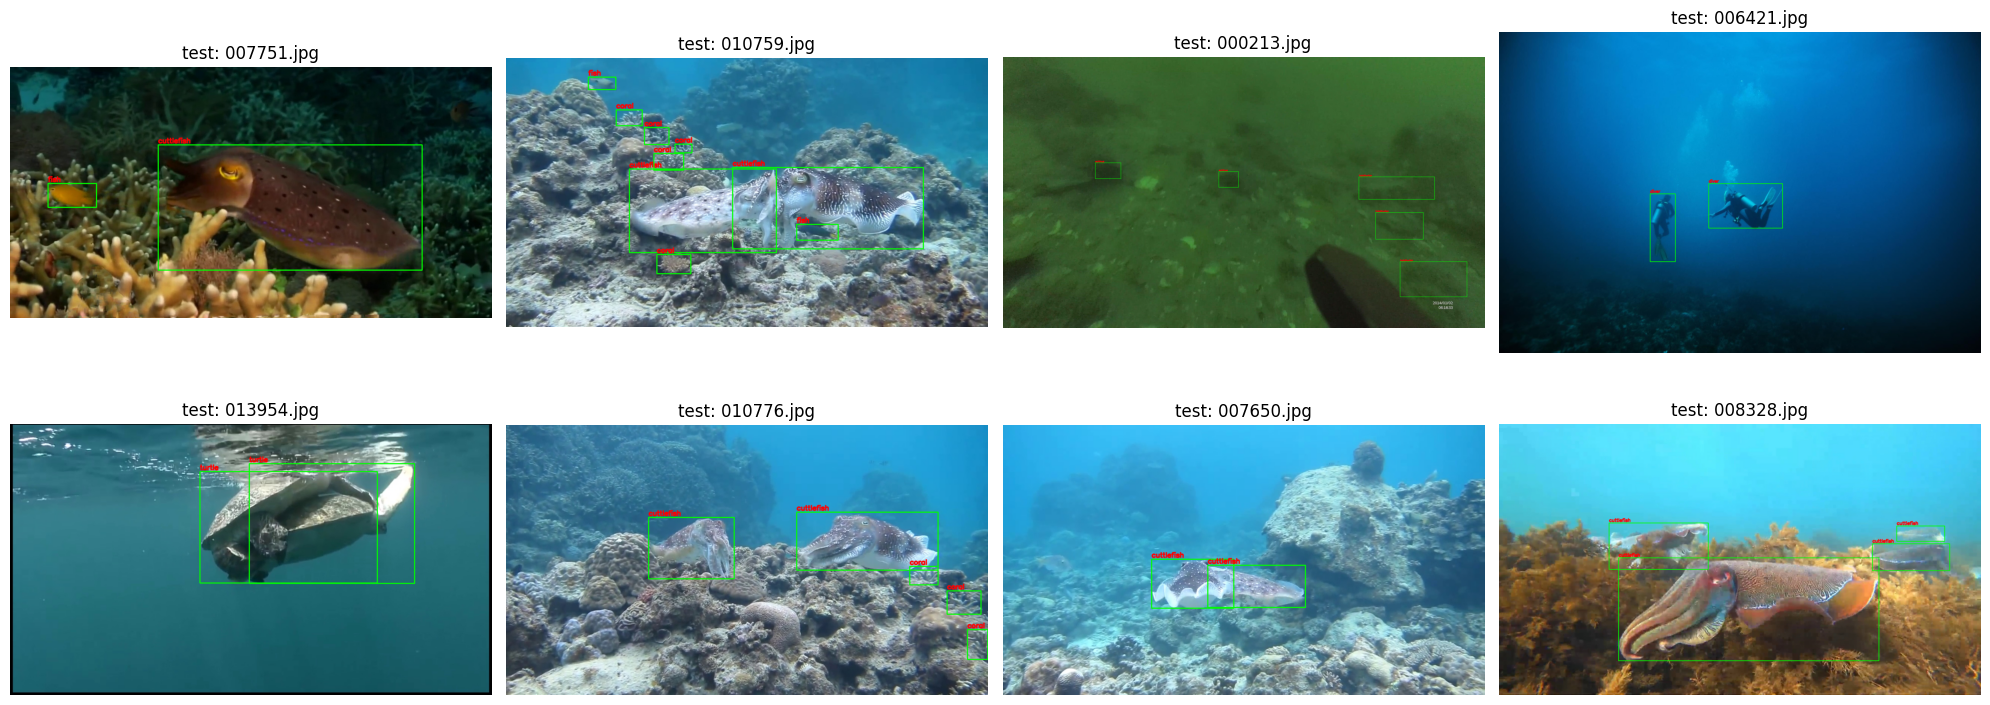

In [2]:
from pathlib import Path
import sys

DATA_PROCESSING_ROOT = Path.cwd().resolve().parents[1]  # RUOD -> vision -> data-processing
sys.path.insert(0, str(DATA_PROCESSING_ROOT))


from utils.yolo_viz import load_yolo_dataset_yaml, show_random_labeled_images

ds = load_yolo_dataset_yaml("ruod.yaml")  # yaml is next to the notebook

split = "test"  # train / val / test
img_dir = {"train": ds.train, "val": ds.val, "test": ds.test}[split]

show_random_labeled_images(
    images_split_dir=img_dir,
    names=ds.names,
    num_pics=8,
    cols=4,
    require_labels=True,
    seed=0,
    title_prefix=f"{split}: ",
)
